In [1]:
import warnings
from IPython.core.interactiveshell import InteractiveShell

# https://github.com/WillKoehrsen/recurrent-neural-networks/blob/master/notebooks/Deep%20Dive%20into%20Recurrent%20Neural%20Networks.ipynb
InteractiveShell.ast_node_interactivity = 'all'

warnings.filterwarnings('ignore', category=RuntimeWarning)

RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True

# Read in data

In [2]:
import pandas as pd
import numpy as np


In [3]:
data = pd.read_csv("character_patents.csv")
# Preprocess data
data = data.dropna(subset=['patent_abstract'])
data = data.drop(data.loc[data['patent_abstract']=="None"].index)
original_abstracts = list(data['patent_abstract'])
len(original_abstracts)

data.head()


4176

,patent_abstract,patent_date,patent_kind,patent_number,patent_title,patent_year
2,Pairs of liquid crystal display pixel electrod...,2000-03-21,A,6040882,"""Liquid crystal display device having """"H"""" ch...",2000
4,A form analyzing unit receives 2-D outline dat...,2005-02-01,B2,6850239,3-D character data generating device and a 3-D...,2005
7,The present invention has an object to enrich ...,2015-09-08,B2,9129261,3D character mail system,2015
8,"A system, method, and software product provide...",2001-12-04,A,6326972,3D stroke-based character modeling suitable fo...,2001
9,A disposable absorbent article may include a c...,2013-06-04,B2,8454572,Absorbent article with improved garment-like c...,2013


# Brief Data exploration

In [4]:
data['patent_abstract'][100]

'In a network game, player characters manipulated by individual players of video game apparatuses belong to the same party to battle with an opponent character. When a player character making a special move is not present in the party, the display screen of each video game apparatus becomes a screen focusing on the player character of the player who uses this video game apparatus. When one of the player characters makes a special move, not only the display screen of the video game apparatus corresponding to this player, but also the display screens of the video game apparatuses corresponding to the other player characters in the party become screens focusing on the player character which makes the special move.'

In [5]:
data['patent_date'].isnull().sum()

0

In [6]:
data['patent_date']

2       2000-03-21
4       2005-02-01
7       2015-09-08
8       2001-12-04
9       2013-06-04
           ...    
4343    1991-01-29
4344    2018-12-18
4345    2021-01-19
4346    2016-03-29
4347    2010-03-09
Name: patent_date, Length: 4176, dtype: object

<ipython-input-7-b7f2742a39c4>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime(int(year), int(month), 1) for year, month in zip(


<AxesSubplot:xlabel='year-month'>

Text(0, 0.5, 'Number of Patents')

Text(0.5, 0, 'Date')

Text(0.5, 1.0, 'Neural Network Patents over Time')

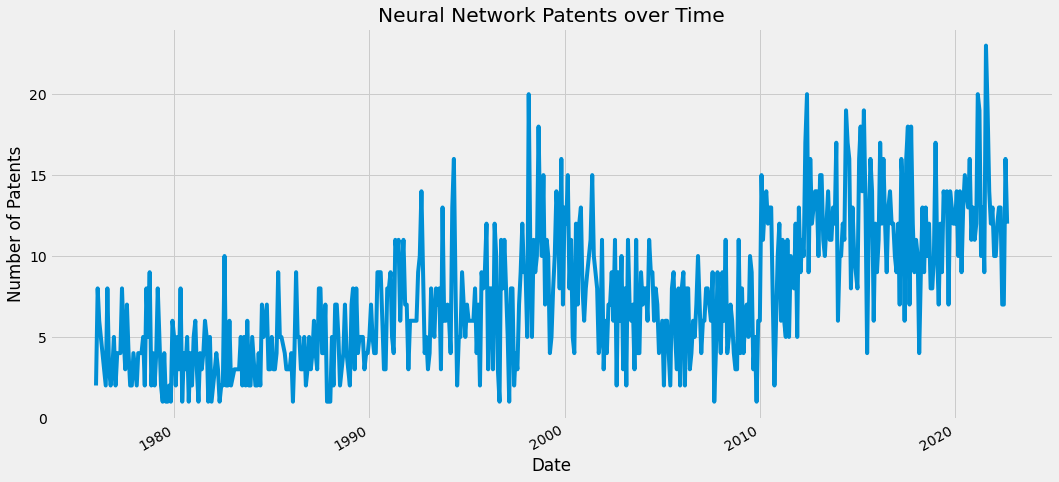

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [
    pd.datetime(int(year), int(month), 1) for year, month in zip(
        data['patent_date'].apply(lambda x: x.split("-")[0]), data['patent_date'].apply(lambda x: x.split("-")[1]))
]

monthly = data.groupby('year-month')['patent_number'].count().reset_index()

monthly.set_index('year-month')['patent_number'].plot(figsize=(16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Neural Network Patents over Time')

<AxesSubplot:xlabel='year-month'>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Patents')

Text(0.5, 1.0, 'Neural Network Patents by Year')

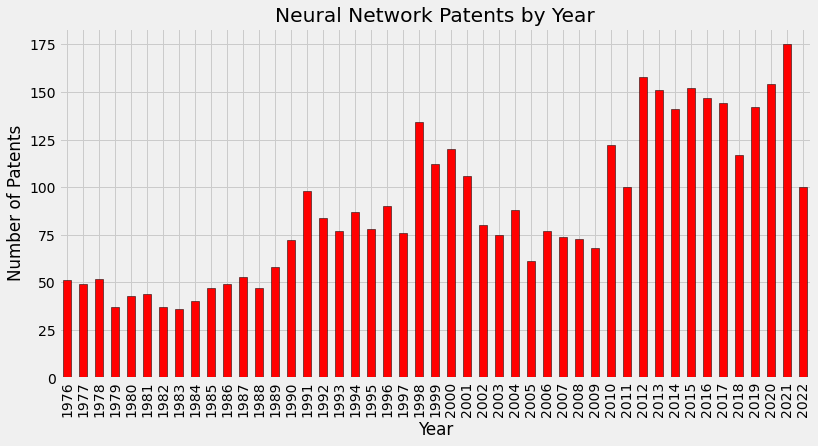

In [8]:
monthly.groupby(monthly['year-month'].dt.year)['patent_number'].sum().plot.bar(
    color='red', edgecolor='k', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

# Data Cleaning

### Seeing what tokenizer does

In [9]:
from keras.preprocessing.text import Tokenizer

example = 'This is a short sentence (1) with one reference to an image. This next sentence, while non-sensical, does not have an image and has two commas.'
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)

'this is a short sentence 1 with one reference to an image this next sentence while non sensical does not have an image and has two commas'

This removes all the punctuation and now we have a random number in the sentence. If we choose to not remove the punctuation, the sentence looks better, but then we have some interesting words in the vocabulary.

In [10]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([example])
s = tokenizer.texts_to_sequences([example])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence (1) with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.'

dict_keys(['this', 'an', 'is', 'a', 'short', 'sentence', '(1)', 'with', 'one', 'reference', 'to', 'image.', 'next', 'sentence,', 'while', 'non-sensical,', 'does', 'not', 'have', 'image', 'and', 'has', 'two', 'commas.'])

Notice that image and image. are classified as distinct words. This is because the period is attached to one and not the other and the same with sentence and sentence,. To alleviate this issue, we can add spaces around the punctuation using regular expressions. We will also remove the image references.

In [11]:
import re


def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    return patent


f = format_patent(example)
f

'This is a short sentence with one reference to an image . This next sentence , while non-sensical , does not have an image and has two commas .'

In [12]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([f])
s = tokenizer.texts_to_sequences([f])[0]
' '.join(tokenizer.index_word[i] for i in s)
tokenizer.word_index.keys()

'this is a short sentence with one reference to an image . this next sentence , while non-sensical , does not have an image and has two commas .'

dict_keys(['this', 'sentence', 'an', 'image', '.', ',', 'is', 'a', 'short', 'with', 'one', 'reference', 'to', 'next', 'while', 'non-sensical', 'does', 'not', 'have', 'and', 'has', 'two', 'commas'])

We no longer have the image and image. problem but we do have separate symbols for . and ,. This means the network will be forced to learn a representation for these punctuation marks (they are also in the pre-trained embeddings). When we want to get back to the original sentence (without image references) we simply have to remove the spaces.

In [13]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent


remove_spaces(' '.join(tokenizer.index_word[i] for i in s))

'this is a short sentence with one reference to an image. this next sentence, while non-sensical, does not have an image and has two commas.'

In [14]:
formatted = []

# Iterate through all the original abstracts
for patent in original_abstracts:
    print(patent)
    formatted.append(format_patent(patent))

len(formatted)

Pairs of liquid crystal display pixel electrodes are fabricated to commonly share a capacitor electrode in the shape of an "H" character which overlaps along periphery portions of the corresponding two pixel electrodes, except for periphery portions thereof respectively connected to corresponding switching devices.
A form analyzing unit receives 2-D outline data stored in an outline data storing unit via an outline data obtaining unit, and judges from the received 2-D outline data whether an outline of a character includes an outline of a hole formed in the character. If so, a top/bottom dividing unit divides an area surrounded by the two outlines into convex polygons. A side generating unit moves each divided structure element in a z-axis direction to generate a side plane of the 3-D character, and generates 3-D data for the character.
The present invention has an object to enrich expression of contents of an e-mail message. In a mobile phone (1), text data (TxD) is input, and a 3D au

4176

# Convert Text to Sequences

A neural network cannot process words, so we must convert the patent abstracts into integers. This is done using the Keras utility Tokenizer. By default, this will convert all words to lowercase and remove punctuation. Therefore, our model will not be able to write complete sentences. However, this can be beneficial for a first model because it limits the size of the vocabulary and means that more of the words (converted into tokens) will have pre-trained embeddings.

Later, we will not remove the capitalization and punctuation when we train our own embeddings.

## Features and Labels

This function takes a few parameters including a training length which is the number of words we will feed into the network as features with the next word the label. For example, if we set training_length = 50, then the model will take in 50 words as features and the 51st word as the label.

For each abstract, we can make multiple training examples by slicing at different points. We can use the first 50 words as features with the 51st as a label, then the 2nd through 51st word as features and the 52nd as the label, then 3rd - 52nd with 53rd as label and so on. This gives us much more data to train on and the performance of the model is proportional to the amount of training data.

In [15]:
def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)

    # Train the tokenizer on the texts
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f'There are {num_words} unique words.')

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            # features will be all the words before the last, label is the last word
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences.')

    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels

Now let's see how our function generates data. For using pre-trained embeddings, we'll remove a fair amount of the punctuation and lowercase all letters but leave in periods and commas. This is because there are no capitalized words in the pre-trained embeddings but there is some punctuation. Our model will not learn how to capitalize words, but it may learn how to end a sentence and insert commas.

In [16]:

TRAINING_LEGNTH = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
# features is training_seq
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, TRAINING_LENGTH, lower=True, filters=filters)

There are 13108 unique words.
There are 347928 training sequences.


Each patent is now represented as a sequence of integers. Let's look at an example of a few features and the corresponding labels. The label is the next word in the sequence after the first 50 words.

In [17]:
n = 3
features[n][:10]

[37, 382, 4043, 234, 13, 73, 9, 12, 234, 13]

In [18]:
# We did not train this yet. but we can use this later to get the predicted correct label
def find_answer(index):
    """Find label corresponding to features for index in training data"""

    # Find features and label
    feats = ' '.join(idx_word[i] for i in features[index])
    answer = idx_word[labels[index]]
    # Features are the first 50 words
    print('Features:', feats)
    # Label is the last word (predicted word)
    print('\nLabel: ', answer)

In [19]:
find_answer(n)

Features: unit receives 2-d outline data stored in an outline data storing unit via an outline data obtaining unit , and judges from the received 2-d outline data whether an outline of a character includes an outline of a hole formed in the character . if so , a top bottom

Label:  dividing


In [20]:
original_abstracts[0]

'Pairs of liquid crystal display pixel electrodes are fabricated to commonly share a capacitor electrode in the shape of an "H" character which overlaps along periphery portions of the corresponding two pixel electrodes, except for periphery portions thereof respectively connected to corresponding switching devices.'

In [21]:
find_answer(100)

Features: to a server , and then , scenario data sd which is control information about 3d graphics is generated in the server . the text data txd and scenario data sd are stored in the server as 3d message information md . when access information to the 3d message information

Label:  md


In [22]:
# We can see the word that is used most often
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

[('the', 44147),
 ('a', 31479),
 ('of', 21969),
 ('.', 16648),
 (',', 16381),
 ('character', 15896),
 ('and', 13353),
 ('to', 12922),
 ('in', 9437),
 ('is', 9083),
 ('for', 7452),
 ('an', 6045),
 ('data', 4519),
 ('by', 4390),
 ('image', 4121)]

The most common words make sense in the context of the patents we are using and the geneal English language.

# Training Data

Next we need to take the features and labels and convert them into training and validation data. The following function does this by splitting the data - after random shuffling because the features were made in sequential order - based on the train_fraction specified. All the inputs are converted into numpy arrays which is the correct input to a keras neural network.

## Encoding of Labels

One important step is to convert the labels to one hot encoded vectors because our network will be trained using categorical_crossentropy and makes a prediction for each word in the vocabulary (we can train with the labels represented as simple integers, but I found performance was better and training faster when using a one-hot representation of the labels). This is done by creating an array of rows of all zeros except for the index of the word which we want to predict - the label - which gets a 1.

In [23]:
from sklearn.utils import shuffle


def create_train_valid(features,
                       labels,
                       num_words,
                       train_fraction=TRAIN_FRACTION):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    # shuffle both features an labels in the same order (1 to 1 mapping is maintained)
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    # TRAIN_FRACTION is 0.7
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc
    gc.enable()
    del features, labels, train_features, valid_features, train_labels, valid_labels
    gc.collect()

    return X_train, X_valid, y_train, y_valid

In [24]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features, labels, num_words)
X_train.shape
y_train.shape

(243549, 50)

(243549, 13108)

We do want to be careful about using up too much memory. One hot encoding the labels creates massive numpy arrays so I took care to delete the un-used objects from the workspace.


In [25]:
import sys
sys.getsizeof(y_train) / 1e9

3.19244042

In [26]:
def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x:10}\tSize: {size} GB.')


check_sizes(gb_min=1)

Object: y_train   	Size: 3.19244042 GB.
Object: y_valid   	Size: 1.36820006 GB.


# Pre-Trained Embeddings

Rather than training our own word embeddings, a very expensive operation, we can use word embeddings that were trained on a large corpus of words. The hope is that these embeddings will generalize from the training corpus to our needs.

This code downloads 100-dimensional word embeddings if you don't already have them. There are a number of different pre-trained word embeddings you can find from Stanford online(https://github.com/stanfordnlp/GloVe).

In [27]:
import os
from keras.utils import get_file

# Vectors to use
glove_vectors = './glove.6B.zip'

Download word embeddings if they are not present
if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip',
                             'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')

# Load in unzipped file
glove_vectors = '/Users/oztinman/rnn/patent_analysis/glove.6B/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400001, 101)

In [28]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

del glove

# Create a word to index dictionary
vectors[100], words[100]

(array([-3.9551e-01,  5.4660e-01,  5.0315e-01, -6.3682e-01, -4.5470e-01,
         3.0889e-01, -4.9240e-02,  2.7191e-01,  3.1562e-01, -3.2879e-01,
         2.5089e-01,  1.4508e-01,  3.5136e-01, -2.2793e-01, -1.5894e-01,
        -5.1527e-01, -2.7978e-01,  3.6470e-01, -3.9425e-01,  3.3299e-01,
         4.3051e-01,  1.8300e-01,  2.5095e-01, -1.8547e-01,  3.4698e-01,
         5.5137e-02, -4.5979e-01, -8.2963e-01, -1.8523e-02, -3.6772e-01,
         4.5566e-02,  7.1052e-01, -2.2782e-02, -8.0889e-02,  2.0685e-01,
         4.9855e-01, -5.9794e-02, -8.0048e-03, -2.3823e-01, -3.3759e-01,
        -2.4201e-01, -2.3788e-01, -1.1362e-03, -4.0395e-01, -4.4859e-01,
        -3.2189e-01,  4.8405e-01, -2.7999e-02,  1.0148e-01, -9.3585e-01,
        -8.7522e-02, -3.9959e-01,  3.6545e-01,  1.3726e+00, -3.0713e-01,
        -2.5940e+00,  2.2431e-01, -4.1168e-02,  1.7765e+00,  4.0010e-01,
        -1.0996e-01,  1.4178e+00, -2.6154e-01,  1.8617e-01,  7.9328e-01,
        -1.1709e-01,  8.7541e-01,  4.3911e-01,  3.4

Next we want to keep only those words that appear in our vocabulary. For words that are in our vocabulary but don't have an embedding, they will be represented as all 0s (a shortcoming that we can address by training our own embeddings.)

In [29]:
vectors.shape

(400001, 100)

In [30]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 2664 words without pre-trained embeddings.


In [31]:
import gc
gc.enable()
del vectors
gc.collect()

0

Each word is represented by 100 numbers with a number of words that can't be found. We can find the closest words to a given word in embedding space using the cosine distance. This requires first normalizing the vectors to have a magnitude of 1.

In [32]:
# Normalize and convert nan to 0
embedding_matrix = embedding_matrix / \
    np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

In [33]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """Find closest words to a query word in embeddings"""

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f'{query} not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f'{query} has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f'Query: {query}\n')
    max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f'Word: {word:15} Cosine Similarity: {round(dist, 4)}')

In [34]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: this            Cosine Similarity: 0.8573
Word: part            Cosine Similarity: 0.8508
Word: one             Cosine Similarity: 0.8503
Word: of              Cosine Similarity: 0.8329
Word: same            Cosine Similarity: 0.8325
Word: first           Cosine Similarity: 0.821
Word: on              Cosine Similarity: 0.82
Word: its             Cosine Similarity: 0.8169
Word: as              Cosine Similarity: 0.8128


In [35]:
find_closest('neural', embedding_matrix, word_idx, idx_word, 10)

Query: neural

Word: neural          Cosine Similarity: 1.0
Word: neurons         Cosine Similarity: 0.6485
Word: sensory         Cosine Similarity: 0.6391
Word: cognitive       Cosine Similarity: 0.6125
Word: artificial      Cosine Similarity: 0.5979
Word: circuitry       Cosine Similarity: 0.5935
Word: cells           Cosine Similarity: 0.5847
Word: synapses        Cosine Similarity: 0.577
Word: molecular       Cosine Similarity: 0.5658
Word: mechanisms      Cosine Similarity: 0.5656


In [36]:
find_closest('.', embedding_matrix, word_idx, idx_word, 10)

Query: .

Word: .               Cosine Similarity: 1.0
Word: but             Cosine Similarity: 0.9049
Word: although        Cosine Similarity: 0.8812
Word: however         Cosine Similarity: 0.8778
Word: ,               Cosine Similarity: 0.8756
Word: when            Cosine Similarity: 0.8729
Word: and             Cosine Similarity: 0.8717
Word: though          Cosine Similarity: 0.8691
Word: it              Cosine Similarity: 0.8654
Word: this            Cosine Similarity: 0.8653


# Build Model

With data encoded as integers and an embedding matrix of pre-trained word vectors, we're ready to build the recurrent neural network. This model is relatively simple and uses an LSTM cell as the heart of the network. After converting the words into embeddings, we pass them through a single LSTM layer, then into a fully connected layer with relu activation before the final output layer with a softmax activation. The final layer produces a probability for every word in the vocab.

When training, these predictions are compared to the actual label using the categorical_crossentropy to calculate a loss. The parameters (weights) in the network are then updated using the Adam optimizer (a variant on Stochastic Gradient Descent) with gradients calculated through backpropagation. Fortunately, Keras handles all of this behind the scenes, so we just have to set up the network and then start the training. The most difficult part is figuring out the correct shapes for the inputs and outputs into the model.

In [37]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

In [38]:
def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=False,
                mask_zero=True))
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                weights=[embedding_matrix],
                trainable=True))

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1))

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1))
    model.add(Dense(128, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1310800   
                                                                 
 masking (Masking)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13108)             1690932   
                                                                 
Total params: 3,052,292
Trainable params: 1,741,492
Non-

The model needs a loss to minimize (categorical_crossentropy) as well as a method for updating the weights using the gradients (Adam). We will also monitor accuracy which is not a good loss but can give us a more interpretable measure of the model performance.

Using pre-trained embeddings means we have about half the parameters to train. However, this also means that the embeddings might not be the best for our data, and there are a number of words with no embeddings.

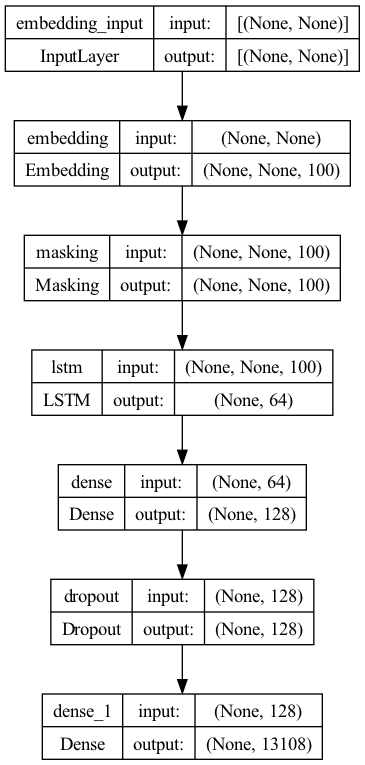

In [41]:
from IPython.display import Image
model_name = 'pre-trained-rnn'

plot_model(model, to_file=f'{model_name}.png', show_shapes=True)

# Image(f'{model_dir}{model_name}.png')

# Train Model

We can now train the model on our training examples. We'll make sure to use early stopping with a validation set to stop the training when the loss on the validation set is no longer decreasing. Also, we'll save the best model every time the validation loss decreases so we can then load in the best model to generate predictions.

### Callbacks
- Early Stopping: Stop training when validation loss no longer decreases
- Model Checkpoint: Save the best model on disk

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

## Depending on your machine, this may take several hours to run

In [43]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

KeyboardInterrupt: 

The accuracy - both training and validation - increase over time and the loss decreases over time which gives us indication that our model is getting better with training.

We can load back in the model so we don't need to repeat the training.

In [ ]:
def load_and_evaluate(model_name, return_model=False):
    """Load in a trained model and evaluate with log loss and accuracy"""

    model = load_model(f'{model_name}.h5')
    r = model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

    valid_crossentropy = r[0]
    valid_accuracy = r[1]

    print(f'Cross Entropy: {round(valid_crossentropy, 4)}')
    print(f'Accuracy: {round(100 * valid_accuracy, 2)}%')

    if return_model:
        return model